In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
import os

2024-06-27 23:50:06.228720: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-27 23:50:07.147726: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def plot_images(images, title, n_rows=10, n_cols=10):
    plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
    plt.suptitle(title, fontsize=16)
    for i, image in enumerate(images[:n_rows * n_cols]):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(image.reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [3]:
data_dir = '../../data'

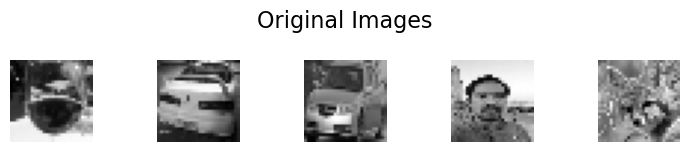

In [4]:
def load_image_data(data_dir, img_size=(28, 28)):
    labels = ['portrait', 'other']
    data = []
    label_data = []
    for label in labels:
        folder_path = os.path.join(data_dir, label)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = load_img(img_path, target_size=img_size, color_mode='grayscale')
            img_array = img_to_array(img).astype('float32') / 255.0
            data.append(img_array.flatten())
            label_data.append(labels.index(label))
    data, label_data = shuffle(np.array(data), np.array(label_data))
    return data, label_data

data, label_data = load_image_data(data_dir)
plot_images(data, title='Original Images', n_rows=1, n_cols=5)

In [5]:
class SOM:
    def __init__(self, m, n, dim, n_iterations, learning_rate=0.5):
        self.m = m  # Hauteur
        self.n = n  # Largeur
        self.dim = dim 
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.weights = np.random.rand(m, n, dim)
        self.initial_learning_rate = learning_rate

    def fit(self, X):
        for iteration in tqdm(range(self.n_iterations), desc="Training SOM"):
            for x in X:
                bmu_index = self.find_bmu(x)
                self.update_weights(x, bmu_index, iteration)

    def find_bmu(self, x):
        distances = np.linalg.norm(self.weights - x, axis=2)
        return np.unravel_index(np.argmin(distances), (self.m, self.n))

    def update_weights(self, x, bmu_index, iteration):
        learning_rate = self.learning_rate * (1 - iteration / self.n_iterations)
        sigma = self.m / 2 * (1 - iteration / self.n_iterations)

        for i in range(self.m):
            for j in range(self.n):
                w = self.weights[i, j]
                d = np.linalg.norm(np.array([i, j]) - np.array(bmu_index))
                if d < sigma:
                    influence = np.exp(-d**2 / (2 * sigma**2))
                    self.weights[i, j] += influence * learning_rate * (x - w)
                    
    def predict(self, X):
        return np.array([self.find_bmu(x) for x in X])


In [6]:
def train_som(data, m, n, dim, n_iterations, learning_rate=0.5):
    som = SOM(m, n, dim, n_iterations, learning_rate)
    som.fit(data)
    return som

som_model = train_som(data, m=10, n=10, dim=data.shape[1], n_iterations=50) 

Training SOM: 100%|██████████| 50/50 [32:40<00:00, 39.20s/it]


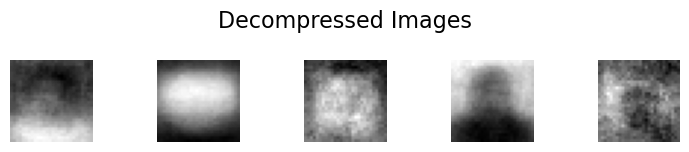

In [7]:
def compress(data, som):
    compressed_data = som.predict(data)
    return compressed_data

def decompress(compressed_data, som):
    decompressed_data = np.array([som.weights[i, j] for i, j in compressed_data])
    return decompressed_data

compressed_data = compress(data, som=som_model)
decompressed_data = decompress(compressed_data, som=som_model)

plot_images(decompressed_data, title='Decompressed Images', n_rows=1, n_cols=5)

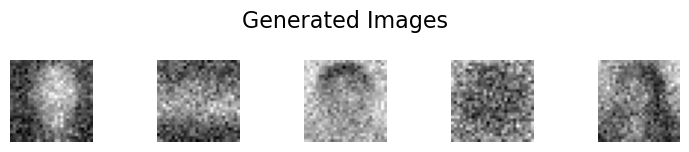

In [8]:
def generate_new_images(som, n_images=10, noise_level=0.1):
    new_images = []
    for _ in range(n_images):
        i = np.random.randint(0, som.m)
        j = np.random.randint(0, som.n)
        cluster_center = som.weights[i, j]
        new_image = cluster_center + np.random.normal(scale=noise_level, size=cluster_center.shape)
        new_image = np.clip(new_image, 0, 1)
        new_images.append(new_image)
    return np.array(new_images)

generated_images = generate_new_images(som_model, n_images=10, noise_level=0.1)
plot_images(generated_images, title='Generated Images', n_rows=1, n_cols=5)